<font size="7">Tanner Sundwall- Backprop CS472</font>

In [259]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import arff
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder
from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import random
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


<font size="5">Algorithm, Methods, etc.</font>

In [260]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, momentum=0, shuffle=True):

        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.network = None
        self.valAccuracies = None
        self.trainingAccuracies = None
        self.trainingMSEs = None
        self.valMSEs = None

    def fit(self, X, y, nOutputs, stop="epochs",epochs=10, epochsMin=100, mseMin=1):
        
        epochsRan = 0
        valAccuracies = []
        trainingAccuracies = []
        valMSEs = []
        trainingMSEs = []
        maxAcc=0
        if stop == "epochs":
            for epoch in range(epochs):
                epochsRan += 1
                if self.shuffle:
                    X,y = self._shuffle_data(X,y,nOutputs)
                run_epoch(self.network, X, y)
                
                y_hats = self.predict(X)
                trainingAcc = class_accuracy(y_hats, y)

                trainingAccuracies.append(trainingAcc)

        elif stop == "validation":
            train, validate = gen_folds(pd.concat([X,pd.DataFrame(y)], axis=1), len(y[0]), .15, shuffle=True)

            lowestMSE = np.Inf
            lastMSE = np.Inf
            accuracyDiff=True
            counter = 0
            
            while accuracyDiff:
                epochsRan += 1
                
                if self.shuffle:
                    X,y = self._shuffle_data(train[0],train[1].values.tolist(),nOutputs)
                    
                run_epoch(self.network, X, y)
                
                y_hats = self.predict(validate[0])
                currAcc = class_accuracy(y_hats, validate[1].values.tolist())
                currMSE = mse(y_hats, validate[1].values.tolist())
                
                y_hats = self.predict(train[0])
                trainingAcc = class_accuracy(y_hats, train[1].values.tolist())
                trainingMSE = mse(y_hats, train[1].values.tolist())
                
                if (currMSE > lastMSE) & (epochsRan > epochsMin) & (mseMin > currMSE) & (counter == 3):
                    accuracyDiff = False
                    
                if currMSE > lowestMSE:
                    counter += 1
                else:
                    lowestMSE = currMSE 
                    counter = 0

                lastMSE = currMSE
                valAccuracies.append(currAcc)
                trainingAccuracies.append(trainingAcc)
                
                valMSEs.append(currMSE)
                trainingMSEs.append(trainingMSE)
                
                if maxAcc < trainingAcc:
                    maxAcc = trainingAcc

                
        print(f"Epochs: {epochsRan}")
        self.valAccuracies = valAccuracies
        self.trainingAccuracies = trainingAccuracies
        self.valMSEs = valMSEs
        self.trainingMSEs = trainingMSEs
        self.epochs = epochsRan
        
        return self
    
    def predict(self, X):

        y_hats = []

        for obsIndex in range(len(X)):
            obs_x = X.iloc[obsIndex,:]

            y_hat, layer = feed_forward(self.network, obs_x)
            y_hats.append(y_hat)

        return y_hats
    
    def score(self, y_hats, y): #use class_accuracy() for multi outputs
        
        errors = []
        
        if type(y[0]) != list:
            
            for y_hatIndex in range(len(y_hats)):
                errors.append(y_hats[y_hatIndex][0] - y[y_hatIndex])
                

            return np.mean(np.array(errors)**2)
        
        else:
            
            return class_accuracy(y_hats,y)
        
    def initialize_weights(self, X, y, structure, initType="zeros", bias=True):
        #biases always init to one

        nFeatures = len(X.columns)
        nOutputs = len(y.columns)
        tensor = []
        layer = 0

        if initType == "zeros":

            tensor.append(np.append(np.zeros((nFeatures,structure[0])),np.zeros((1,structure[0])),axis=0))

            for layer in range(1, len(structure)):
                tensor.append(np.append(np.zeros((structure[layer-1],structure[layer])),np.zeros((1,structure[layer])),axis=0))

            tensor.append(np.append(np.zeros((structure[layer],nOutputs)),np.zeros((1,nOutputs)),axis=0))
            
        else:
            
            tensor.append(np.append(np.random.uniform(-1,1,(nFeatures,structure[0])),np.random.uniform(-1,1,(1,structure[0])),axis=0))

            for layer in range(1, len(structure)):
                tensor.append(np.append(np.random.uniform(-1,1,(structure[layer-1],structure[layer])),np.random.uniform(-1,1,(1,structure[layer])),axis=0))

            tensor.append(np.append(np.random.uniform(-1,1,(structure[layer],nOutputs)),np.random.uniform(-1,1,(1,nOutputs)),axis=0))

        return tensor


    def _shuffle_data(self, X, y, nOutputs):

        df = pd.concat([X, pd.DataFrame(y)], axis=1)
        df = df.sample(frac=1)
        df = df.reset_index(drop=True)
        
        nFeatures = len(df.columns) - nOutputs
        
        X = df.iloc[:, :nFeatures]
        y = df.iloc[:, nFeatures:]
        y = y.values.tolist()

        return X, y #X: pd series, y: list

class Network():

    def __init__(self, X, y, structure, weightsTensor, lr, momentum):

        self.X = X
        self.y = y
        self.lr = lr
        self.momentum = momentum
        self.inputNodes = []
        self.outputNodes = []
        self.structure = structure
        self.weightsTensor = weightsTensor
        self.allEdges = [] #NOT SORTED----use only for weight updates

    def induce_network(self, bias=True, dense=True):

        numFeatures = len(self.X.columns)

        for inputNodeIndex in range(numFeatures): #init input nodes
            currInputNode = Node("input", self.X.columns[inputNodeIndex])
            self.inputNodes.append(currInputNode)

        if bias:
            biasNode = Node("input (bias)", 1,1)
            self.inputNodes.append(biasNode)


        for layerIndex in range(len(self.structure)):

            currWeightsMatrix = self.weightsTensor[layerIndex]
            currHLNodes = []
            currLayerHeight = self.structure[layerIndex]

            for currNodeInLayer in range(currLayerHeight):

                currNode = Node("hidden",currNodeInLayer)
                currHLNodes.append(currNode)

                if layerIndex == 0: #connect input layer to first hidden layer
                    for inputNodeIndex in range(numFeatures+bias):
                        currNode.connectNodes(self, self.inputNodes[inputNodeIndex], "input", currWeightsMatrix[inputNodeIndex,currNodeInLayer])
                else:
                    for prevLayerNodeIndex in range(self.structure[layerIndex-1]+bias):

                        currNode.connectNodes(self, prevHLNodes[prevLayerNodeIndex], "hidden", currWeightsMatrix[prevLayerNodeIndex,currNodeInLayer])

            if bias:
                biasNode = Node("input (bias)", 1,1)
                currHLNodes.append(biasNode)

            prevHLNodes = currHLNodes

        if type(self.y[0]) != list:
            numOutputs = 1
        else:
            numOutputs = len(self.y[0])

        currWeightsMatrix = self.weightsTensor[-1]

        for outputNodeIndex in range(numOutputs):

            currOutputNode = Node("output", None)

            for prevLayerNodeIndex in range(currLayerHeight+bias): #use height of last layer
                currOutputNode.connectNodes(self, prevHLNodes[prevLayerNodeIndex], "output", currWeightsMatrix[prevLayerNodeIndex,outputNodeIndex])

            self.outputNodes.append(currOutputNode)

    def set_input_vals(self, x):

        for featureIndex in range(len(x)):
            self.inputNodes[featureIndex].val = x[featureIndex]

    def get_node(self, location): #returns incoming weights for a node at location specified

        weights = []

        layer, index = location

        if layer > 1:
            nextLayer = self.inputNodes[0]

            for siftLayer in range(layer-1):
                nextLayer = nextLayer.rightEdges[0].rightNode

            targetNode = nextLayer.rightEdges[index-1].rightNode

        elif layer == 1:
            targetNode = self.inputNodes[0].rightEdges[index-1].rightNode

        for edge in targetNode.leftEdges:
            weights.append(edge.weight)

        return targetNode, weights

    def get_small_delta(self, location):

        node = self.get_node(location)[0]
        rightWeights = []
        rightSmallDeltas = []

        for rightEdge in node.rightEdges: #for each of its forward children...
            rightWeights.append(rightEdge.weight) #collect weights
            rightSmallDeltas.append(rightEdge.rightNode.smallDelta) #collect deltas

        deltaSums = np.array(rightWeights).dot(np.array(rightSmallDeltas)) #take dot product (sum term)
        smallDelta = deltaSums * deactivate(node.val) #sum*f'(net_j)
        node.smallDelta = smallDelta

        return smallDelta, node

    def update_weights(self):

        for edge in self.allEdges:
            deltaWithMomentum = edge.weightDelta + (self.momentum*edge.weightDeltaPrev)
            edge.weight += deltaWithMomentum
            edge.weightDeltaPrev = deltaWithMomentum

    def get_weights(self):

        hiddenLayer = 0
        allWeights = []
        for edge in self.allEdges:
            allWeights.append(edge.weight)

        weightsTensor = []
        nFeatures = len(self.weightsTensor[0])

        currIndex = nFeatures * self.structure[0]
        firstMatrix = allWeights[:currIndex]

        weightsTensor.append(np.array(firstMatrix).reshape(self.structure[0],nFeatures).T)

        for hiddenLayer in range(1,len(self.structure)):
            numWeights = (self.structure[hiddenLayer-1]+1)*self.structure[hiddenLayer]
            nextMatrix = allWeights[currIndex:currIndex+numWeights]
            currIndex += numWeights
            weightsTensor.append(np.array(nextMatrix).reshape(self.structure[hiddenLayer]+1,self.structure[hiddenLayer-1]).T)

        lastMatrix = allWeights[currIndex:]
        nOutcomes = self.weightsTensor[-1].shape[1]
        weightsTensor.append(np.array(lastMatrix).reshape(nOutcomes,self.structure[hiddenLayer]+1).T)

        return weightsTensor

    def pk(self):

        space = ""
        print(f"# input nodes: {len(self.inputNodes)}")
        currNode = self.inputNodes[0]

        rightEdgesExist = True

        while rightEdgesExist:
            space += " "
            try:
                print(space + currNode.type)
                print(space + "|" + str(currNode.rightEdges[0].weight))
                currNode = currNode.rightEdges[0].rightNode
            except:
                rightEdgesExist = False

class Edge():

    def __init__(self, leftNode, rightNode, weight=None):
        self.leftNode = leftNode
        self.rightNode = rightNode
        self.weight = weight
        self.weightDelta = None
        self.weightDeltaPrev = 0 #init to zero for first obs


class Node():

    def __init__(self, nodeType=None, nodeId=None, val=None):
        self.rightEdges = []
        self.leftEdges = []
        self.type = nodeType
        self.nodeId = nodeId
        self.val = val
        self.smallDelta = None

    def connectNodes(self, network, leftNode, connectionType, weight):
        #self is rightnode; connects to prev node backward
        newEdge = Edge(leftNode, self, weight)
        self.leftEdges.append(newEdge)
        leftNode.rightEdges.append(newEdge)

        network.allEdges.append(newEdge)

        if connectionType == "input":
            self.type = "hidden"
            #leftNode.type = "input"

        elif connectionType == "hidden":
            self.type = "hidden"
            #leftNode.type = "hidden"

        else:
            self.type = "output"
            #leftNode.type = "hidden"

   

In [234]:
def activate(x): #sigmoid

    return 1 / (1 + math.exp(-x))

def deactivate(x):

    return x*(1-x)

def eval_obs(network, x, y, lr=None): #x passed in as vector (obs)

    y_hat, layer = feed_forward(network, x)

    backprop(network, x, y, y_hat, lr, layer)
    
def feed_forward(network, x):
    network.set_input_vals(x)

    inputVec = x.tolist()
    inputVec.append(1)

    for layer in range(1,len(network.structure)+1):

        currLayerVals = []

        for nodeInLayer in range(1,network.structure[layer-1]+1):

            node, weights = network.get_node([layer, nodeInLayer])
            weights = np.array(weights)

            if layer == 1:
                net = weights.dot(np.array(inputVec))
            else:
                net = weights.dot(np.array(lastLayerVals))

            node.val = activate(net)
            currLayerVals.append(node.val)

        currLayerVals.append(1) #add bias node value
        lastLayerVals = currLayerVals

    y_hat = []
    for outputNode in network.outputNodes:
        weights = []

        for finalEdgeLayer in range(1,network.structure[layer-1]+2):

            weights.append(outputNode.leftEdges[finalEdgeLayer-1].weight)

        net = np.array(weights).dot(np.array(lastLayerVals))
        outputNode.val = activate(net)
        y_hat.append(outputNode.val)

    return y_hat, layer

def backprop(network, x, y, y_hat, lr, layer):
    ###BACKPROP
    deltaBases = []

    if len(y_hat) == 1:
        deltaBases.append((y - y_hat[0]) * deactivate(y_hat[0]))
    else:
        for outputVal in range(len(y_hat)):
            deltaBases.append((y[outputVal]-y_hat[outputVal])*deactivate(y_hat[outputVal]))

    currOutputNodeIndex = 0
    ###OUTPUT BACKPROP
    for outputNode in network.outputNodes:

        for nodeInBackLayer in range(network.structure[layer-1]+1):

            Z_i = outputNode.leftEdges[nodeInBackLayer].leftNode.val
            outputNode.leftEdges[nodeInBackLayer].weightDelta = lr*deltaBases[currOutputNodeIndex]*Z_i #C*delta_j*Z_i
        outputNode.smallDelta = deltaBases[currOutputNodeIndex]
        currOutputNodeIndex += 1

    for hiddenLayer in range(len(network.structure),0,-1): #at each layer...

        for nodeInLayer in range(1,network.structure[hiddenLayer-1]+1): #get a node...

            smallDelta, currBackNode = network.get_small_delta([hiddenLayer, nodeInLayer])

            for currEdge in currBackNode.leftEdges: #eval each incoming node

                Z_i = currEdge.leftNode.val
                currEdge.weightDelta = lr * smallDelta * Z_i #C*delta_j*Z_i

def run_epoch(network, X, y):

    for obsIndex in range(len(X)):
        obs_x = X.iloc[obsIndex,:]
        obs_y = y[obsIndex]

        eval_obs(network, obs_x, obs_y,lr=.1)
        network.update_weights()

def fit(network, X, y, epochs=10):

    for epoch in range(epochs):
        run_epoch(network, X, y)

def hot_encode(yInput):

    y = pd.Series(yInput)
    y = pd.get_dummies(y, columns = set(yInput))
    return y#.values.tolist()

def gen_folds(df, numOutputs, pctTraining, shuffle=True):

    if shuffle:
        df = df.sample(frac=1)
        df = df.reset_index(drop=True)
    
    nFeatures = len(df.columns) - numOutputs

    X = df.iloc[:, :nFeatures]
    y = df.iloc[:,nFeatures:]

    n = len(X)
    nSplit = int(n * pctTraining)
    XTraining = X[:nSplit]
    yTraining = y[:nSplit]
    XTest = X[nSplit:]
    yTest = y[nSplit:]

    return [XTraining, yTraining], [XTest, yTest]

def convert_to_binary_result(y_hat):
    
    y_hatStaged = [0] * len(y_hat)
    y_hatStaged[y_hat.index(np.max(y_hat))] = 1
    y_hat = y_hatStaged
    
    return y_hat

def class_accuracy(y_hats,y):

    accuracies = []
    for obs in range(len(y_hats)):

        y_hat_binary = convert_to_binary_result(y_hats[obs])
        accuracies.append(np.array(y_hat_binary).dot(np.array(y[obs])))

    return np.mean(np.array(accuracies))

def mse(y_hats,y):
    
    mseList = []
    
    for obsIndex in range(len(y)):
        
        mseList.append(np.linalg.norm(np.array(y_hats[obsIndex])-np.array(y[obsIndex])))
    
    return np.mean(mseList)
    

<font size="5">1.1.1- Debug</font>

In [292]:
data = arff.loadarff("linsep2nonorigin.arff")
df = pd.DataFrame(data[0])

#df = pd.read_csv("debug_bp_0.csv")
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
for item in range(len(y)):
    y[item] = int.from_bytes(y[item], "little") - 48

mlp = MLP(shuffle=False)
tensor = mlp.initialize_weights(X,pd.DataFrame(y),[4])
mlp.network = Network(X,y, [4], tensor,.1,.5)
mlp.network.induce_network()
mlp.fit(X, y, 1, epochs=10)
mlp.network.get_weights()

Epochs: 10


[array([[-8.81779797e-05, -8.81779797e-05, -8.81779797e-05,
         -8.81779797e-05],
        [ 7.82757731e-04,  7.82757731e-04,  7.82757731e-04,
          7.82757731e-04],
        [-3.94353645e-03, -3.94353645e-03, -3.94353645e-03,
         -3.94353645e-03]]),
 array([[-0.01060888],
        [-0.01060888],
        [-0.01060888],
        [-0.01060888],
        [-0.02145495]])]

In [293]:
data = arff.loadarff("linsep2nonorigin.arff")
df = pd.DataFrame(data[0])

#df = pd.read_csv("debug_bp_0.csv")
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
for item in range(len(y)):
    y[item] = int.from_bytes(y[item], "little") - 48

y = hot_encode(y)
    
mlp = MLP(shuffle=False)
tensor = mlp.initialize_weights(X,y,[4])
mlp.network = Network(X,y.values.tolist(), [4], tensor,.1,.5)
mlp.network.induce_network()
mlp.fit(X, y.values.tolist(), 2, epochs=10)
mlp.network.get_weights()


Epochs: 10


[array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
        [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
        [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]),
 array([[ 0.01050642, -0.01050642],
        [ 0.01050642, -0.01050642],
        [ 0.01050642, -0.01050642],
        [ 0.01050642, -0.01050642],
        [ 0.02148778, -0.02148778]])]

<font size="5">1.1.2- Evaluation</font>

In [294]:
data = arff.loadarff("data_banknote_authentication.arff")
df = pd.DataFrame(data[0])
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
for item in range(len(y)):
    y[item] = int.from_bytes(y[item], "little") - 48

mlp = MLP(shuffle=False)
tensor = mlp.initialize_weights(X,pd.DataFrame(y),[4])
mlp.network = Network(X,y, [4], tensor,.1,.5)
mlp.network.induce_network()
mlp.fit(X, y, 1, epochs=10)
mlp.network.get_weights()


Epochs: 10


[array([[ 1.30932366,  1.30932366,  1.30932366,  1.30932366],
        [ 0.80601033,  0.80601033,  0.80601033,  0.80601033],
        [ 0.92744187,  0.92744187,  0.92744187,  0.92744187],
        [ 0.22165294,  0.22165294,  0.22165294,  0.22165294],
        [-1.45313731, -1.45313731, -1.45313731, -1.45313731]]),
 array([[-1.88512443],
        [-1.88512443],
        [-1.88512443],
        [-1.88512443],
        [ 4.57969955]])]

<font size="5">2- Iris Dataset</font>

In [144]:
data = arff.loadarff("iris.arff")
df = pd.DataFrame(data[0])
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y = hot_encode(y)

mlp = MLP(shuffle=True)
tensor = mlp.initialize_weights(X,pd.DataFrame(y),[8])
mlp.network = Network(X,y.values.tolist(), [8], tensor,.1,0)
mlp.network.induce_network()
train, test = gen_folds(pd.concat([X,pd.DataFrame(y)],axis=1), 3, .8)
mlp = mlp.fit(train[0], train[1].values.tolist(), 3, stop="validation", epochsMin=100, mseMin=.45)

Epochs: 949


In [145]:
y_hats = mlp.predict(test[0])
testAcc = class_accuracy(y_hats, test[1].values.tolist())
print(f'Test Accuracy: {testAcc}')

Test Accuracy: 0.9666666666666667


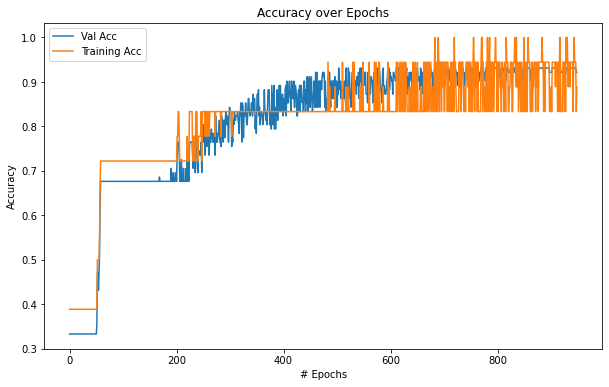

In [146]:
plt.figure(figsize=(10,6))
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.plot(mlp.valAccuracies, label="Val Acc")
plt.plot(mlp.trainingAccuracies, label="Training Acc")
foo = plt.legend()

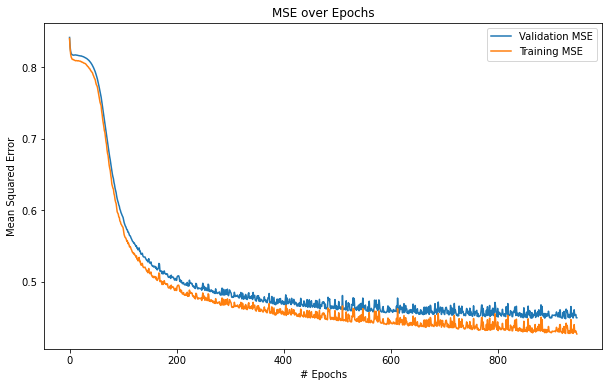

In [147]:
plt.figure(figsize=(10,6))
plt.xlabel("# Epochs")
plt.ylabel("Mean Squared Error")
plt.title("MSE over Epochs")
plt.plot(mlp.valMSEs, label="Validation MSE")
plt.plot(mlp.trainingMSEs, label="Training MSE")
plt.legend()

*The "validation" stopping criteria used throughout the lab use a minimum # of epochs and a lower-bound MSE value for "early" stopping. The main criteria for stopping is the number of epochs without and improvement in lowest MSE (hard-coded to 3)

<font size="5">3- Vowel Dataset</font>

In [290]:
data = arff.loadarff("vowel.arff")
df = pd.DataFrame(data[0])


# x_0 = hot_encode(df['Train or Test'])
# x_1 = hot_encode(df['Speaker Number'])
# x_2 = hot_encode(df['Sex'])

del df['Speaker Number']
del df['Sex']
del df['Train or Test']

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y = hot_encode(y)

validationSetMSEs = []
LRs = []

for trial in range(5):
    lr = random.uniform(0, 1)
    LRs.append(lr)
    
    mlp = MLP(shuffle=False)
    tensor = mlp.initialize_weights(X,pd.DataFrame(y),[20], initType="rand")
    mlp.network = Network(X,y.values.tolist(), [20], tensor,lr,0.5)
    mlp.network.induce_network()
    train, test = gen_folds(pd.concat([X,y],axis=1), 11, .8)
    mlp.fit(train[0], train[1].values.tolist(), 11, stop="validation", epochsMin = 20)
    
    validationSetMSEs.append(mlp.valMSEs)
    
    y_hats = mlp.predict(test[0])
    testAcc = class_accuracy(y_hats, test[1].values.tolist())
    print(f'{round(lr,2)} LR Test Accuracy: {testAcc}')
    

Epochs: 361
0.36 LR Test Accuracy: 0.8434343434343434
Epochs: 781
0.64 LR Test Accuracy: 0.8535353535353535
Epochs: 249
0.19 LR Test Accuracy: 0.7828282828282829
Epochs: 820
0.64 LR Test Accuracy: 0.8838383838383839
Epochs: 314
0.6 LR Test Accuracy: 0.8434343434343434


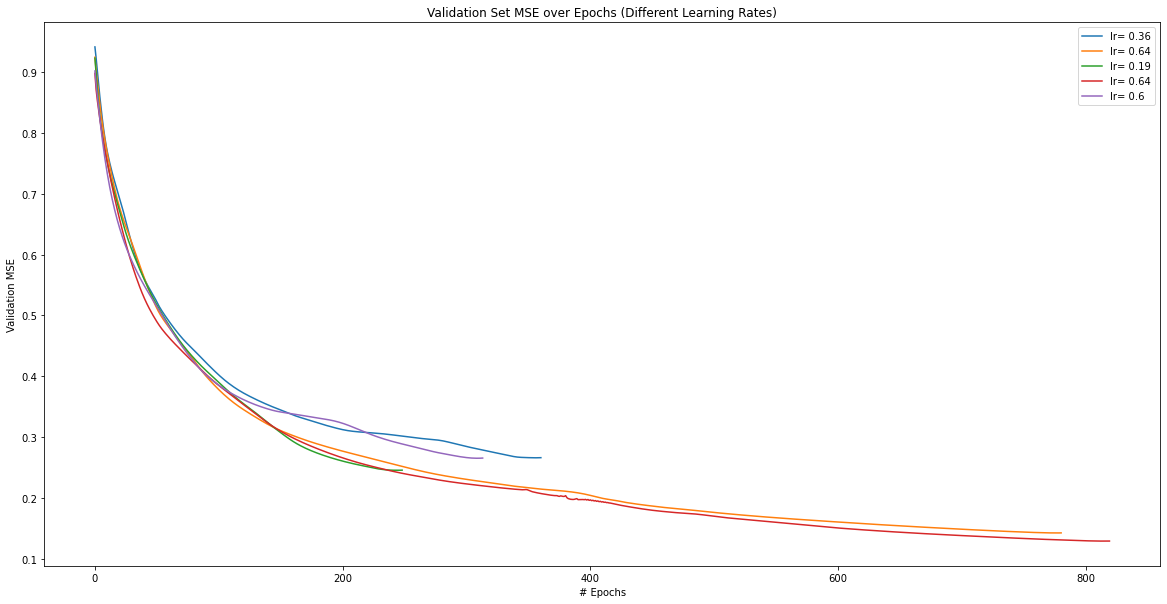

In [291]:
plt.figure(figsize=(20,10))

plt.xlabel("# Epochs")
plt.ylabel("Validation MSE")
plt.title("Validation Set MSE over Epochs (Different Learning Rates)")

for trial in range(5):
    plt.plot(validationSetMSEs[trial],label=f"lr= {round(LRs[trial],2)}")

plt.legend()

<font size="5">3.1- Discussion</font>

*Graph results may vary; non-deterministic

Learning rates appear to have drastic differences in convergence time. Performance appeared fairly similar. The smallest learning rate took the longest to converge, but appeared to have the lowest convergence MSE in most cases. It shows quick improvement in accuracy in the early epochs, and begins flattening out later. It looks like learning rate may not be as correlated with convergence time as I initially thought; sometimes the most "medium" learning rates converge quickest. In the initial simulation, lr=0.04 ended up with the lowest MSE, so this was chosen for future analyses.

This is an inherently more complicated dataset than the 'Iris' dataset. First, it has 11 output classes instead of 3. "Guesses" become far less likely, and accuracies will be lower. More output classes also increases computation time. If $k$ represents the number of nodes in the last hidden layer and $m$ indicates the increase in class size, there will be $kn$ more weights in the network, all else unchanged. 

By inspection, it appears as though some of the features included in the dataset may not be necessary inclusions. The 'Train/Test' column and the 'Speaker Name' column appear to be noise; the data category and speaker likely won't affect the vowel class. While we could include these with no harmful affect, we may as well omit them. Model accuracies did not significantly decrease after deleting these features. This was a beneficial omission, as dimensionality reduction helps interpretability and computational efficiency.

<font size="5">3.2- Hidden Nodes Analysis</font>

In [286]:
accImprovement = True
currNodes = 1

lr=.04

bestTrainingMSEs = []
bestValidationMSEs = []
nodeCount = []
lastBestAccuracy = 0

while accImprovement:
    
    mlp = MLP()
    tensor = mlp.initialize_weights(X,pd.DataFrame(y),[currNodes],initType="rand")
    mlp.network = Network(X,y.values.tolist(), [currNodes], tensor,lr,0)
    mlp.network.induce_network()
    train, test = gen_folds(pd.concat([X,y],axis=1), 11, .8)
    mlp.fit(train[0], train[1].values.tolist(), 11, stop="validation", epochsMin = 10)
    
    bestTrainingMSEs.append(np.min(mlp.trainingMSEs))
    bestValidationMSEs.append(np.min(mlp.valMSEs))
    
    if np.max(mlp.valAccuracies) < lastBestAccuracy:
        accImprovement = False
        
    lastBestAccuracy = np.max(mlp.valAccuracies)
    
    y_hats = mlp.predict(test[0])
    testAcc = class_accuracy(y_hats, test[1].values.tolist())
    print(f'{currNodes} Nodes Test Accuracy: {testAcc}')
    
    nodeCount.append(currNodes)
    currNodes = currNodes*2
    

Epochs: 16
1 Nodes Test Accuracy: 0.0707070707070707
Epochs: 22
2 Nodes Test Accuracy: 0.09090909090909091
Epochs: 28
4 Nodes Test Accuracy: 0.12121212121212122
Epochs: 345
8 Nodes Test Accuracy: 0.5151515151515151
Epochs: 88
16 Nodes Test Accuracy: 0.3383838383838384


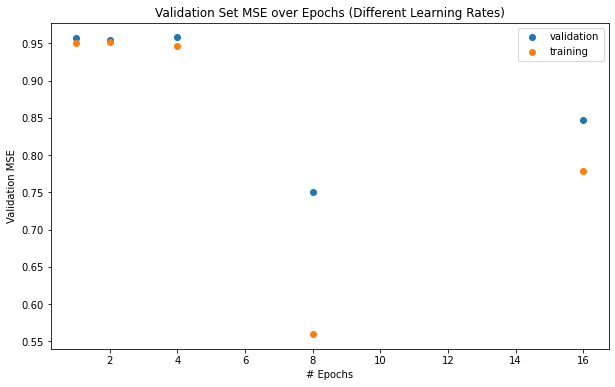

In [287]:
plt.figure(figsize=(10,6))

plt.xlabel("# Epochs")
plt.ylabel("Validation MSE")
plt.title("Validation Set MSE over Epochs (Different Learning Rates)")

plt.scatter(nodeCount,bestValidationMSEs,label="validation")
plt.scatter(nodeCount,bestTrainingMSEs,label="training")

foo = plt.legend()

Over a few iterations, it appears 8 to 16 nodes are optimal for a one hidden layer network. These optimal models drop below a training validation MSE of 0.75, and average test accuracies around 45%. It is interesting to note that the gap between validation and training MSE increases as the model gets larger. This may be a sign of overfitting, which is already a known problem as networks get larger. The greater this gap gets, the less generalizable the model is. The 1 node model, on the other hand, suffers from bias; overfitting is low, but new information is underutilized.

The 8 node result was most common, and is used in the next section.

<font size="5">3.3- Momentum Analysis</font>

In [278]:
hiddenNodes = 8
lr = .04

numEpochs = []
momentums = []

for trial in range(10):
    momentum = random.uniform(0, 1)
    momentums.append(momentum)
    
    mlp = MLP()
    tensor = mlp.initialize_weights(X,pd.DataFrame(y),[hiddenNodes],initType="rand")
    mlp.network = Network(X,y.values.tolist(), [hiddenNodes], tensor,lr,momentum)
    mlp.network.induce_network()
    train, test = gen_folds(pd.concat([X,y],axis=1), 11, .8)
    mlp.fit(train[0], train[1].values.tolist(), 11, stop="validation", epochsMin = 10)
    
    numEpochs.append(mlp.epochs)
    
    y_hats = mlp.predict(test[0])
    testAcc = class_accuracy(y_hats, test[1].values.tolist())
    print(f'{round(momentum,2)} Momentum Test Accuracy: {testAcc}')
    

    

Epochs: 90
0.04 Momentum Test Accuracy: 0.2727272727272727
Epochs: 141
0.14 Momentum Test Accuracy: 0.35353535353535354
Epochs: 112
0.14 Momentum Test Accuracy: 0.3434343434343434
Epochs: 166
0.09 Momentum Test Accuracy: 0.4090909090909091
Epochs: 174
0.17 Momentum Test Accuracy: 0.4696969696969697
Epochs: 78
0.58 Momentum Test Accuracy: 0.40404040404040403
Epochs: 101
0.63 Momentum Test Accuracy: 0.4595959595959596
Epochs: 84
0.41 Momentum Test Accuracy: 0.3282828282828283
Epochs: 197
0.07 Momentum Test Accuracy: 0.45454545454545453
Epochs: 58
0.79 Momentum Test Accuracy: 0.37373737373737376


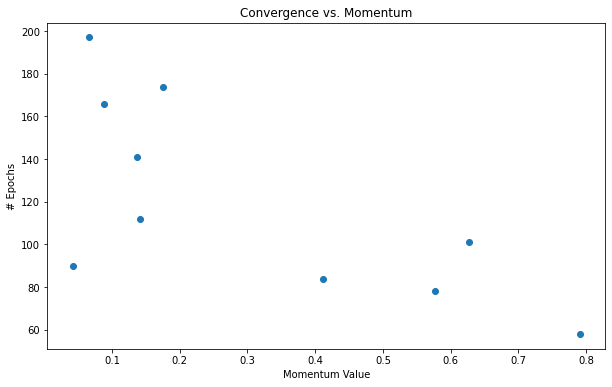

In [279]:
plt.figure(figsize=(10,6))

plt.xlabel("Momentum Value")
plt.ylabel("# Epochs")
plt.title("Convergence vs. Momentum")

plt.scatter(momentums,numEpochs)


Momentum and convergence time have a clear relationship as seen above. A higher momentum coefficient "speeds up" the process; and we see that it takes less epochs to converge. Essentially, the momentum uses previous weight deltas to accelerate movement in the weight space. Those models with low momentum values took much longer (see above). 

Are there accuracy implications? It doesn't immediately appear so. This may imply that higher coefficients should be favored, but this analysis is likely missing some nuance. The best "combination" of accuracy and convergence speed in one specific instance was 0.63, so I will add this to my tuple of optimal hyperparameters.

<font size="5">4.1- scikit MLP Analysis (Iris)</font>

In [282]:
data = arff.loadarff("iris.arff")
df = pd.DataFrame(data[0])
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y = hot_encode(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
scikit_mlp = MLPClassifier(hidden_layer_sizes=[20], activation='tanh',learning_rate_init=.1, momentum=.1)

scikit_mlp.fit(X_train,y_train)

print(f'Test Accuracy: {scikit_mlp.score(X_test, y_test)}')

print(f'# Epochs: {scikit_mlp.n_iter_}')

Test Accuracy: 0.975
# Epochs: 114


I tested several hyperparameters in scikit on the Iris dataset. High learning rates (like .9) did very poorly; often predicting less than 40% correct. A quick jump to 90%+ accuracy occurs around lr<.4. I found this weird, since in my LR analysis with my algorithm, high learning rates weren't necessarily worse. Most activation functions performed similarly; although the "linear" activation (i.e. the net) performed much worse. Momentum didn't appear to affect accuracy or convergence time (contradicts my own analysis). When using SGD and Nestorov's Momentum, accuracy appears to drop to the low 80s. 

By setting early_stopping to True, results became much more volatile; accuracies ranged from .6 to .98. The key difference was number of epochs; while 150+ epochs were previously run, this subset usually saw less than 50. This tradeoff is expected; hence the riskiness of early stopping. 

The alpha of the l2 regularization term appeared to have little affect on convergence and test accuracies. 

While adjusting network structure, I noticed that when hidden layers are added, test accuracy became quite volatile. This was the same for layers with lots of nodes. This may signify overfitting.

The params above are those that appeared best upon initial observation.

<font size="5">4.2- scikit Hyperparameter Grid Search (Iris)</font>

In [257]:
#grid search using # layers, layer size, learning rate and momentum

LRs = np.arange(.1, .6, 0.1)
momentums = np.arange(.1, .6, 0.1)
hiddenLayers = np.arange(1,5,1)
layerSize = np.arange(1,50,5)

hyperparamTuple = ()
maxAcc = 0

for size in layerSize:

    for hiddenLayer in hiddenLayers:

        for lr in LRs:

            for momentum in momentums:
                
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
                scikit_mlp = MLPClassifier(hidden_layer_sizes=[8]*hiddenLayers, activation='logistic',learning_rate_init=lr, momentum=momentum)
                scikit_mlp.fit(X_train,y_train)
                
                if scikit_mlp.score(X_test, y_test) > maxAcc:
                    maxAcc = scikit_mlp.score(X_test, y_test)
                    hyperparamTuple = (size,hiddenLayer,lr,momentum)

print(f'Max Test Accuracy: {round(maxAcc,4)}')
print(f'Argmax Hyperparameters: {hyperparamTuple} (layer size, # layers, LR, momentum)')

Max Test Accuracy: 0.975
Argmax Hyperparameters: (11, 2, 0.1, 0.5) (layer size, # layers, LR, momentum)


For the Iris dataset, I formed a 4-dimensional grid with embedded loops with the following hyperparameters: learning rate, momentum, # of layers, and layer size. The above parameters maximized test accuracy, usually above 95%. The corresponding parameters were 2 hidden layers of 11 nodes, a learning rate of 0.1, and a momentum term of 0.5. Other than the two layers, these follow similar suit to the hyperparameters widely considered best, and those used in this lab.

<font size="5">5- scikit Hyperparameter Random Search (Vowel)</font>

In [274]:
data = arff.loadarff("vowel.arff")
df = pd.DataFrame(data[0])

del df['Speaker Number']
del df['Sex']
del df['Train or Test']

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y = hot_encode(y)

maxAcc = 0

for trial in range(100):
    
    lr = random.uniform(0,1)
    momentum = random.uniform(0,1)
    layerSize = random.randint(1,100)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
    scikit_mlp = MLPClassifier(hidden_layer_sizes=[layerSize], activation='logistic',learning_rate_init=lr, momentum=momentum)
    scikit_mlp.fit(X_train,y_train)

    if scikit_mlp.score(X_test, y_test) > maxAcc:
        maxAcc = scikit_mlp.score(X_test, y_test)
        hyperparamTuple = (layerSize,lr,momentum)

print(f'Max Test Accuracy: {round(maxAcc,4)}')
print(f'Argmax Hyperparameters: {hyperparamTuple} (layer size, LR, momentum)')

Max Test Accuracy: 0.5354
Argmax Hyperparameters: (53, 0.09713298135839288, 0.44409071655055865) (layer size, LR, momentum)


The optimal hyperparameter values returned by scikit are fairly similar to those found in my own analysis. My learning rate was 0.04, and this random search returned 0.09. The momentum value I chose was 0.63, and scikit found 0.44.

The only substantial difference was the number of nodes. Scikit found that 53 nodes was an optimal number, while my analysis used 8. This could be due to early stopping in the algorithm used I used to chose number of nodes. Over a few iterations, it never found more than 16 useful, but there are likely higher values that work "just as well". The point of the method used in the lab is to not overuse nodes; it assumes that if the next doubling of nodes was worse, the last iteration was best. If 16 or 32 nodes wasn't better than 8, higher values were never even evaluated. 